In [1]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import mplhep as hep
import pandas as pd
hep.style.use(hep.style.CMS)
import hist as hist2

from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.nanoevents.methods import candidate, vector
from coffea.analysis_tools import Weights, PackedSelection

# we suppress ROOT warnings where our input ROOT tree has duplicate branches - these are handled correctly.
import warnings
import uproot
from coffea import processor
import warnings 
from datetime import datetime
import pickle

warnings.filterwarnings('ignore')

In [19]:
#https://twiki.cern.ch/twiki/bin/viewauth/CMS/EgHLTRunIISummary
class triggerEffWbProcessor(processor.ProcessorABC):
    def __init__(self):
        self.make_output = lambda: {
            'sum': 0.,
            'pt_e_tr': hist2.Hist(
                hist2.axis.Regular(24, 30, 500, name='pt_e_tr'),
                ),
            'pt_e_tc': hist2.Hist(
                hist2.axis.Regular(24, 30, 500, name='pt_e_tc'),
                ),
            'eta_e_tr': hist2.Hist(
                hist2.axis.Regular(50, -2.4, 2.4, name='eta_e_tr'),
                ),
            'eta_e_tc': hist2.Hist(
                hist2.axis.Regular(50,-2.4, 2.4, name='eta_e_tc'),
                ),
            'met_tr': hist2.Hist(
                hist2.axis.Regular(30, 50, 500, name='met_tr'),
                ),
            'met_tc': hist2.Hist(
                hist2.axis.Regular(30, 50, 500, name='met_tc'),
                ),
            'pt_bjet_tr': hist2.Hist(
                hist2.axis.Regular(24, 30, 500, name='pt_bjet_tr'),
                ),
            'pt_bjet_tc': hist2.Hist(
                hist2.axis.Regular(24, 30, 500, name='pt_bjet_tc'),
                ),
            'eta_bjet_tr': hist2.Hist(
                hist2.axis.Regular(50, -2.1, 2.1, name='eta_bjet_tr'),
                ),
            'eta_bjet_tc': hist2.Hist(
                hist2.axis.Regular(50, -2.1, 2.1, name='eta_bjet_tc'),
                )
        }
    @property 
    def accumulator(self):
        return self._accumulator

    def process(self, events):
        dataset = events.metadata['dataset']
        #weights = Weights(len(events), storeIndividual=True)
        #weights.add('genweight', events.genWeight)
        
        selection = PackedSelection()
        
        output =self.make_output()
        
        output['sum'] = len(events)
        
        #b-jet
        b_jet=events.Jet[(events.Jet.jetId==6) & (events.Jet.puId==7) &(events.Jet.btagDeepFlavB>0.4506)]#[events.Jet.btagCSVV2>0.8484]
        events["bjet"]=b_jet
        
        #trigger
        
        trigger_de_ref=events.HLT.IsoMu27#Ele23_Ele12_CaloIdL_TrackIdL_IsoVL # isumuon27

        trigger_central=events.HLT.Ele35_WPTight_Gsf
        
        #ID IDENTIFICADOR DE e y muon
        events["heeplecton"]=events.Electron[events.Electron.cutBased_HEEP]
        events["mediumIdmuon"]=events.Muon[events.Muon.mediumId]
                       

        #1 electron
        goodelectronselection = ((ak.sum(events.heeplecton.pt>0, axis=1)==1)
                &(((0<abs(events.heeplecton.eta)) & (abs(events.heeplecton.eta)<2.4))
                & ((1.57<abs(events.heeplecton.eta)) | (abs(events.heeplecton.eta)<1.4)))
               )

        events["electronselect"]=events.heeplecton[goodelectronselection]

        goodelectron=((ak.pad_none(events.electronselect.pt, 1)[:,0]>30))
        
        #Muon
        events["muonsid"]=events.Muon[(abs(events.mediumIdmuon.eta)<2.4) & (events.mediumIdmuon.pt>30)] 
        #1 muon
        goodmuon=((ak.sum(events.muonsid.pt>0, axis=1)==1))

        
        
        #b-jet
        
        goodbJets = ((ak.sum(events.bjet.pt>0, axis=1)>1)
            &(ak.firsts(events.bjet.pt)>30)
            &(abs(ak.firsts(events.bjet.eta))<2.1)
             )
        
        #met
        
        #goodMet=events.MET.pt>50
        
        #seleccion
        
        selection.add("trigger_de_ref",trigger_de_ref)
        selection.add("trigger_central",trigger_central)
        selection.add("muon",goodmuon)
        selection.add("electron",goodelectron)
        selection.add("bJet",goodbJets)
        #selection.add("Met",goodMet)
        
        #regions
        
        
        regions={"signal_trigger":["trigger_de_ref"],
         "signal_trigger_e":["trigger_de_ref","electron"],
         "signal_trigger_e_bjet":["trigger_de_ref","electron","bJet"],
         "signal_triggerref_e_bjet_met":["muon","electron","bJet","trigger_de_ref"],
         "signal_triggerctl_e_bjet_met":["muon","electron","bJet","trigger_de_ref","trigger_central"],
                }
        
        #candidates
        
        candidtae_events_ref=events[selection.all(*regions["signal_triggerref_e_bjet_met"])]
        candidtae_events_ctl=events[selection.all(*regions["signal_triggerctl_e_bjet_met"])]
        
        
            
        #selection out
        # pt e
        output['pt_e_tr'].fill(pt_e_tr = ak.firsts(candidtae_events_ref.electronselect.pt))
        output['pt_e_tc'].fill(pt_e_tc = ak.firsts(candidtae_events_ctl.electronselect.pt))
        
        #eta e
        output['eta_e_tr'].fill(eta_e_tr = ak.firsts(candidtae_events_ref.electronselect.eta))
        output['eta_e_tc'].fill(eta_e_tc = ak.firsts(candidtae_events_ctl.electronselect.eta))
        
        #Met
        output['met_tr'].fill(met_tr = candidtae_events_ref.MET.pt)
        output['met_tc'].fill(met_tc = candidtae_events_ctl.MET.pt)
        
        #pt bjet
        output['pt_bjet_tr'].fill(pt_bjet_tr = ak.firsts(candidtae_events_ref.bjet.pt))
        output['pt_bjet_tc'].fill(pt_bjet_tc = ak.firsts(candidtae_events_ctl.bjet.pt))
        
        #eta bjet
        
        output['eta_bjet_tr'].fill(eta_bjet_tr = ak.firsts(candidtae_events_ref.bjet.eta))
        output['eta_bjet_tc'].fill(eta_bjet_tc = ak.firsts(candidtae_events_ctl.bjet.eta))
        
        
        return {dataset: output}
            
    def postprocess(self, accumulator):
        return accumulator

In [20]:
import json
archivos_data="TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8"
# Opening JSON file
f = open("./fileset/"+archivos_data+".txt")
 
# returns JSON object as
# a dictionary
load_data = json.load(f)
datos=[]

#for i in range(2):
 #   datos.append("root://xcache/"+load_data[archivos_data][i])

for i in load_data[archivos_data]:
    datos.append("root://xcache/"+i)

In [21]:
len(datos)

85

In [22]:
fileset={archivos_data:datos}

In [23]:
out = processor.run_uproot_job(
    fileset,
    treename='Events',
    processor_instance=triggerEffWbProcessor(),
    executor=processor.futures_executor,
    executor_args={
        "schema": processor.NanoAODSchema,
         "workers": 58
        #"client": client,
    }
    #executor=processor.dask_executor,
    #executor_args={"schema": processor.NanoAODSchema, "client":client}#"workers": 4},
    #maxchunks=None,
)

Preprocessing:   0%|          | 0/85 [00:00<?, ?file/s]

Processing:   0%|          | 0/1063 [00:00<?, ?chunk/s]

# Save Date

In [24]:
procesador="triggerEffWbProcessor"
name_archivo=procesador+"-"+archivos_data+"-"+datetime.now().strftime('%Y-%m-%d:%H:%M')
name_archivo

'triggerEffWbProcessor-TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8-2022-03-28:04:24'

In [25]:
file = open("./salida_ejecucion/"+name_archivo+".pkl",'wb')
pickle.dump(out,file)
file.close()

# graficas

In [26]:
out[archivos_data]["sum"]
#106.978.000 en 2:59:03 min
#350.819.620 electrones
#769.081.942 muones

106978000

In [27]:
def get_value(den):
    return den.values()

def get_axis(den):
    return [den.axes.bin(i)[0][0] for i in range(len(den.values())+1)]

In [28]:
def graficar_hist(data,labels,namesave,xmin=0,xmax=600):
    plt.plot(igsize=(12, 4))
    hep.cms.lumitext("(13 TeV)")
    hep.cms.text("Work in Progress")
    hep.histplot(data.values(),bins=np.array(get_axis(data)),
                 color="black",density=True,label=labels)
    plt.xlim(xmin,xmax)
    plt.legend()
    plt.xlabel(labels)
    plt.savefig(namesave)

In [29]:
from hist.intervals import clopper_pearson_interval
def error(num, den):
    return abs(
        clopper_pearson_interval(num.values(), den.values()) - num.values() / den.values()
    )

def graf_eficience(num,den,labels,namesave,bar_error=False,ymin=0.8,ymax=1.03,xmin=0,xmax=600):
    hep.cms.lumitext("(13 TeV)")
    hep.cms.text("Work in Progress")
    eficience=np.array(num.values()/den.values())
    bines=np.array(get_axis(num))
    eficience[np.isnan(eficience)] = 0
    hep.histplot(eficience,bins=bines,label=labels)
    
    if bar_error:
        el_err = error(num, den)
        hep.histplot(eficience,bins=bines,yerr=el_err,histtype='errorbar',fmt="ko",
             capsize=3,label="error")    
    
    plt.ylim(ymin,ymax)
    plt.xlim(xmin,xmax)
    plt.legend()
    plt.xlabel(labels)
    plt.savefig(namesave)

# $P_{T}(e)$

In [32]:
pt_e_tr=out[archivos_data]["pt_e_tr"]
pt_e_tc=out[archivos_data]["pt_e_tc"]

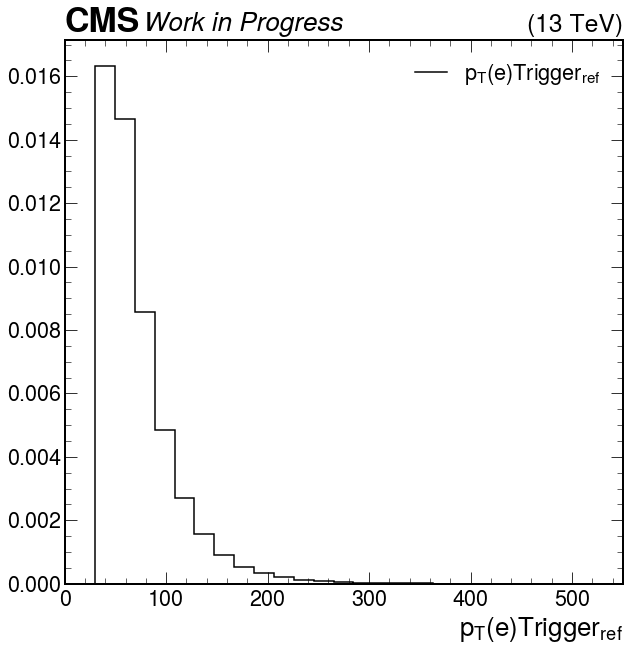

In [33]:
graficar_hist(pt_e_tr,labels="${p}_{T}(e) Trigger_{ref}$",
              namesave="./graf_16_03/pt_e_trigger_ref.jpg",
             xmin=0,xmax=550)

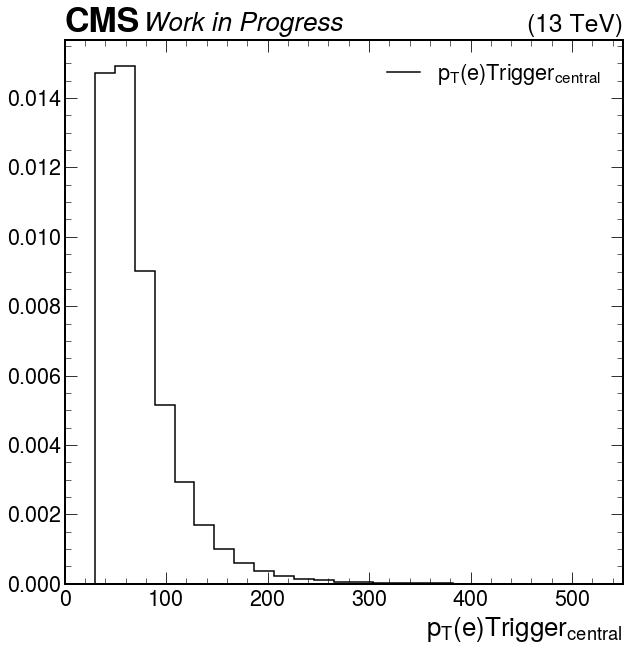

In [34]:
graficar_hist(pt_e_tc,labels="${p}_{T}(e) Trigger_{central}$",
              namesave="./graf_16_03/pt_e_trigger_ctl.jpg",
             xmin=0,xmax=550)

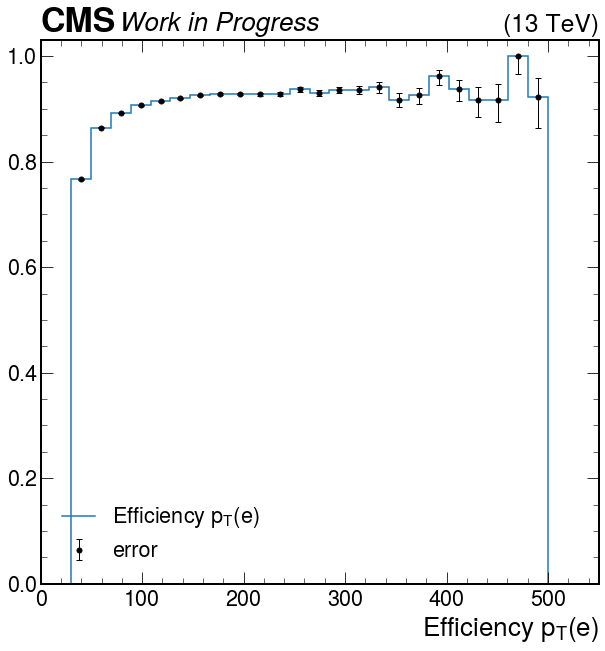

In [35]:
graf_eficience(pt_e_tc,pt_e_tr,bar_error=True,
               labels="Efficiency ${p}_{T}(e)$",
               namesave="./graf_16_03/Efficiency_pt_e.jpg",
              xmin=0,xmax=550,ymin=0)

In [36]:
eta_e_tr=out[archivos_data]["eta_e_tr"]
eta_e_tc=out[archivos_data]["eta_e_tc"]

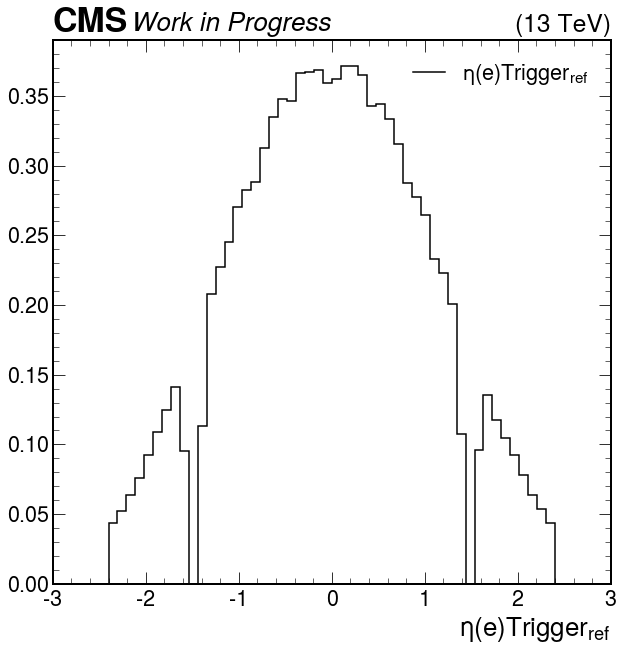

In [37]:
graficar_hist(eta_e_tr,labels="$\eta(e) Trigger_{ref}$",
              namesave="./graf_16_03/eta_e_trigger_ref.jpg",
             xmin=-3,xmax=3)

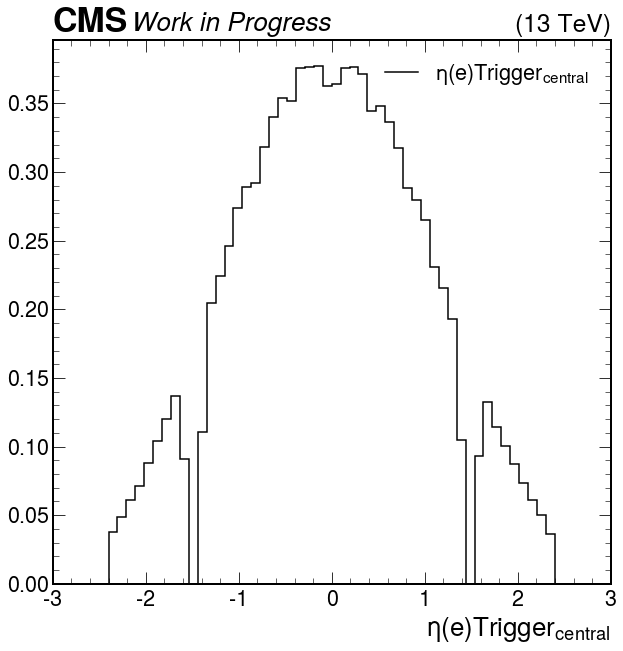

In [53]:
graficar_hist(eta_e_tc,labels="$\eta(e) Trigger_{central}$",
              namesave="./graf_16_03/eta_e_trigger_ctl.jpg",
             xmin=-3,xmax=3)

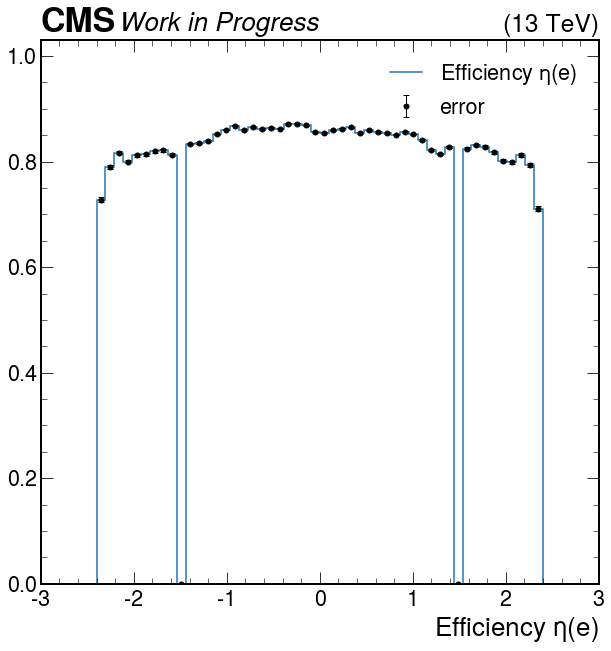

In [60]:
graf_eficience(eta_e_tc,eta_e_tr,bar_error=True,labels="Efficiency $\eta (e)$",
               namesave="./graf_16_03/Efficiency_eta_e.jpg",
              xmin=-3,xmax=3,ymin=0)

In [41]:
met_tr=out[archivos_data]["met_tr"]
met_tc=out[archivos_data]["met_tc"]

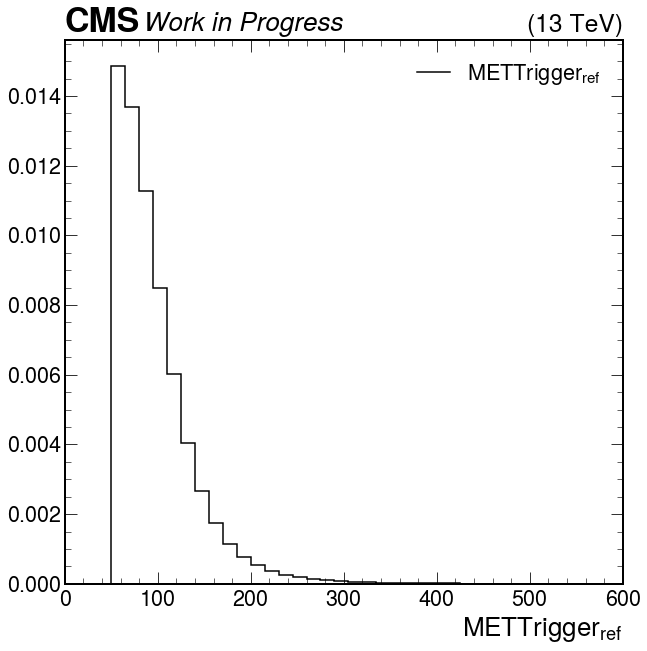

In [42]:
graficar_hist(met_tr,labels="$MET Trigger_{ref}$",
              namesave="./graf_16_03/met_trigger_ref.jpg",
             xmin=0,xmax=600)

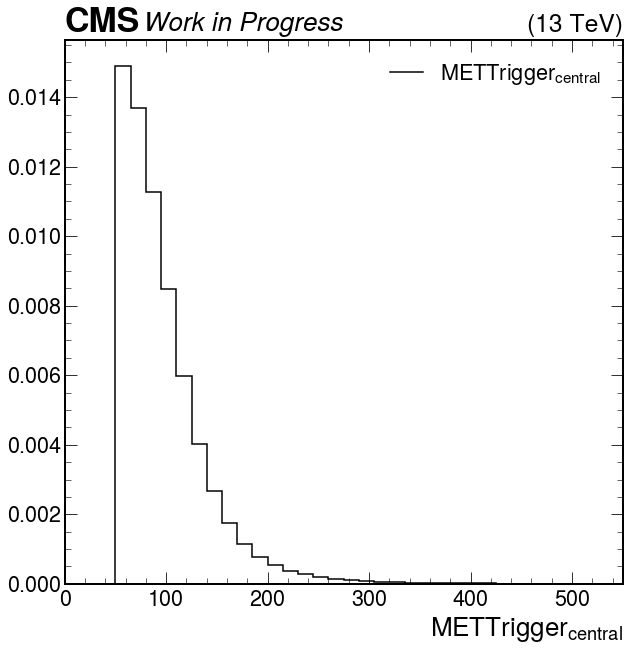

In [43]:
graficar_hist(met_tc,labels="$MET Trigger_{central}$",
              namesave="./graf_16_03/met_trigger_ctl.jpg",
             xmin=0,xmax=550)

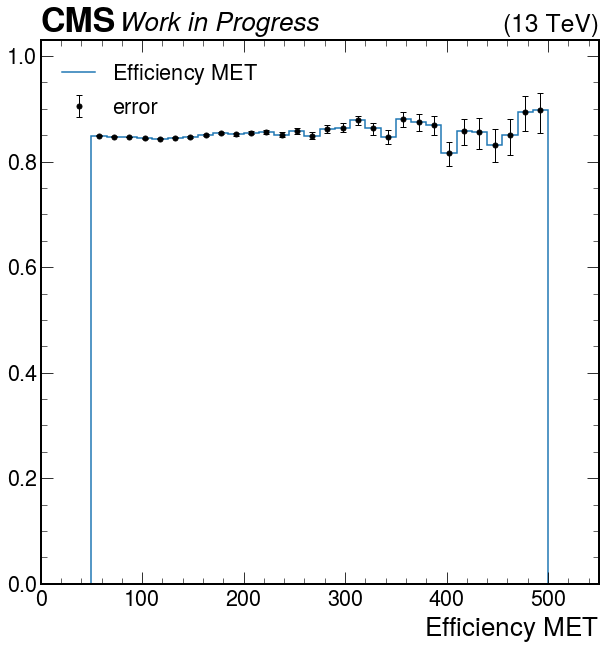

In [44]:
graf_eficience(met_tc,met_tr,bar_error=True,labels="Efficiency $MET$",
               namesave="./graf_16_03/Efficiency_met_e.jpg",
              xmin=0,xmax=550,ymin=0)

In [45]:
pt_bjet_tr=out[archivos_data]["pt_bjet_tr"]
pt_bjet_tc=out[archivos_data]["pt_bjet_tc"]

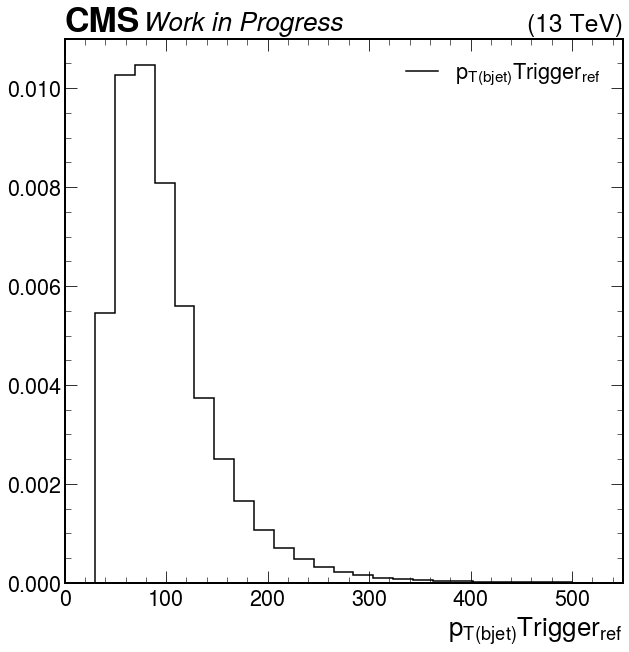

In [46]:
graficar_hist(pt_bjet_tr,labels="${{p}_{T}}_{(bjet)} Trigger_{ref}$",
              namesave="./graf_16_03/pt_bjet_trigger_ref.jpg",
             xmin=0,xmax=550)

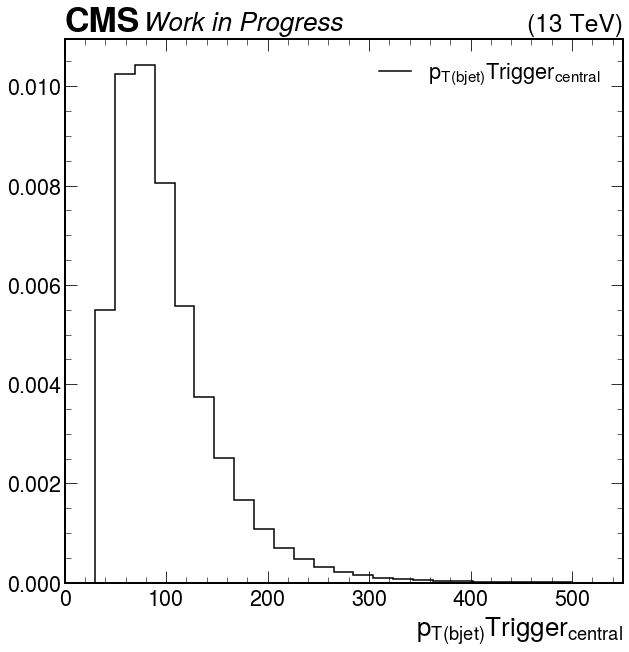

In [47]:
graficar_hist(pt_bjet_tc,labels="${{p}_{T}}_{(bjet)} Trigger_{central}$",
              namesave="./graf_16_03/pt_bjet_trigger_ctl.jpg",
             xmin=0,xmax=550)

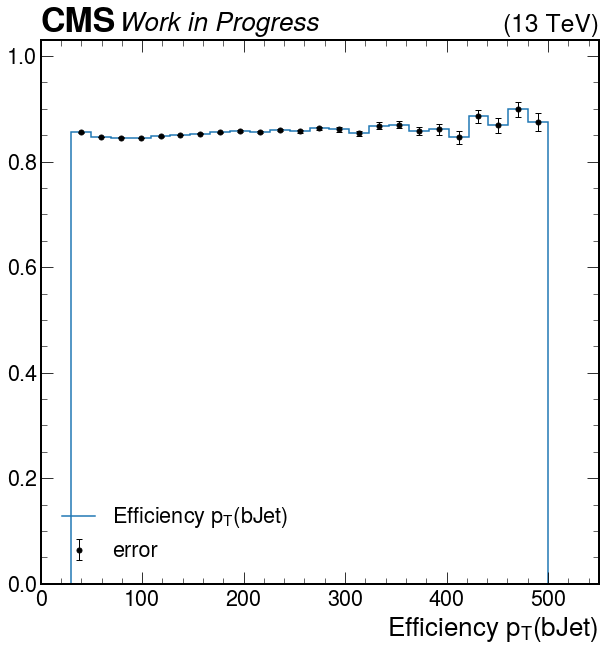

In [48]:
graf_eficience(pt_bjet_tc,pt_bjet_tr,bar_error=True,
               labels="Efficiency ${p}_{T}(bJet)$",
               namesave="./graf_16_03/Efficiency_pt_bjet.jpg",
              xmin=0,xmax=550,ymin=0)

In [49]:
eta_bjet_tr=out[archivos_data]["eta_bjet_tr"]
eta_bjet_tc=out[archivos_data]["eta_bjet_tc"]

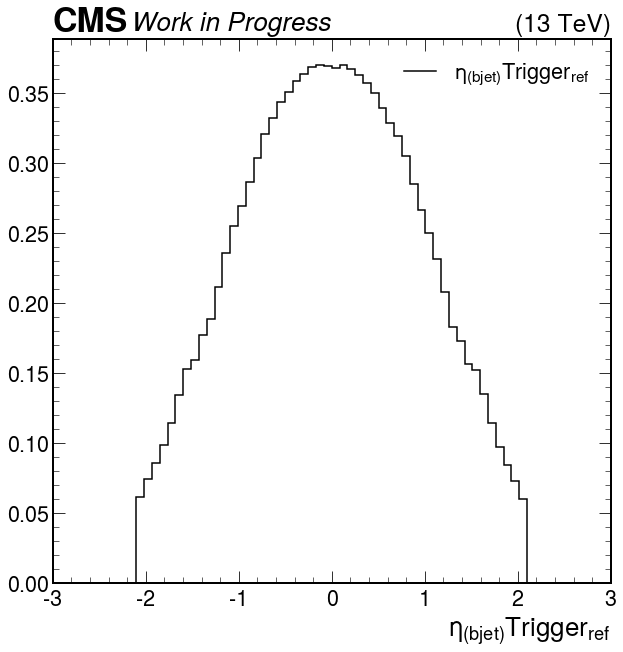

In [50]:
graficar_hist(eta_bjet_tr,labels="${\eta}_{(bjet)} Trigger_{ref}$",
              namesave="./graf_16_03/eta_bjet_trigger_ref.jpg",
             xmin=-3,xmax=3)

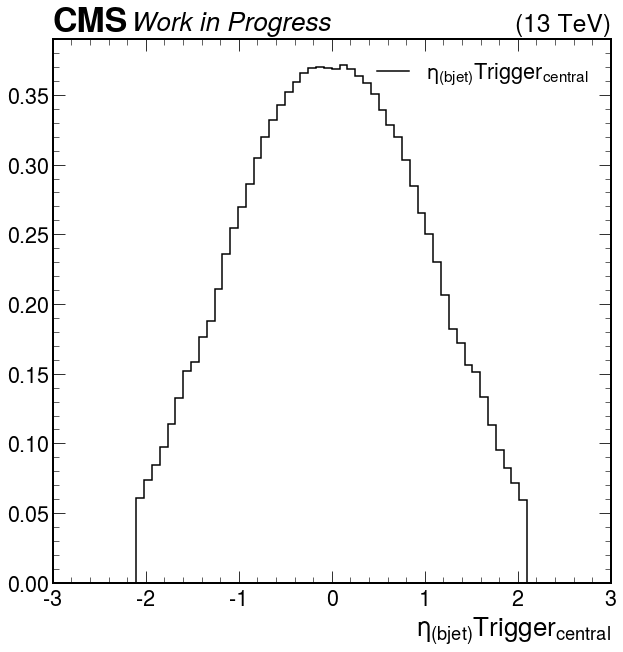

In [51]:
graficar_hist(eta_bjet_tc,labels="${\eta}_{(bjet)} Trigger_{central}$",
              namesave="./graf_16_03/eta_bjet_trigger_ctl.jpg",
             xmin=-3,xmax=3)

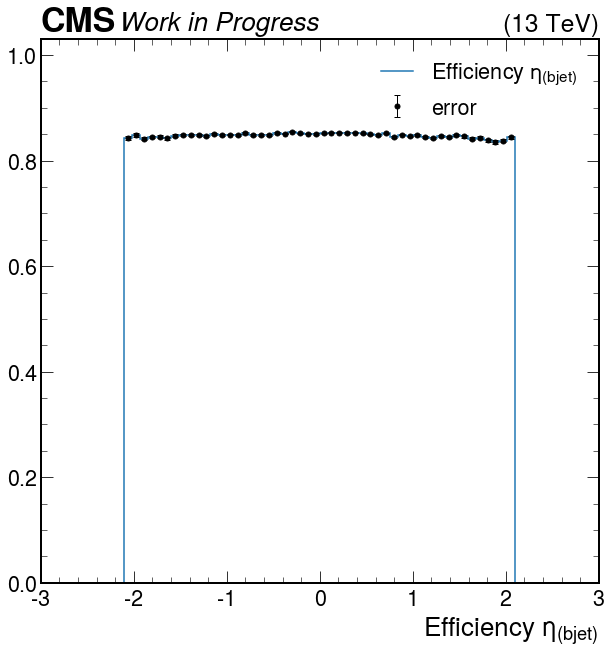

In [52]:
graf_eficience(eta_bjet_tc,eta_bjet_tr,bar_error=True,
               labels="Efficiency ${\eta}_{(bjet)}$",
               namesave="./graf_16_03/Efficiency_eta_bjet.jpg",
              xmin=-3,xmax=3,ymin=0)